In [1]:
import random,math,argparse
import numpy as np
from numpy.random.mtrand import sample
from matplotlib import patches, pyplot as plt
import networkx as nx
from scipy import sparse

parser = argparse.ArgumentParser()
parser.add_argument('--mode', default='default', type=str)#parameters setting
parser.add_argument('--n', default=10, type=int)          #number of DAG  nodes
parser.add_argument('--max_out', default=2, type=float)   #max out_degree of one node
parser.add_argument('--alpha',default=1,type=float)       #shape
parser.add_argument('--beta',default=1.0,type=float)      #regularity
args = parser.parse_args()

set_dag_size = [20,30,40,50,60,70,80,90]             #random number of DAG  nodes
set_max_out = [1,2,3,4,5]                              #max out_degree of one node
set_alpha = [0.5,1.0,1.5]                            #DAG shape
set_beta = [0.0,0.5,1.0,2.0]                         #DAG regularity

def DAGs_generate(mode = 'default', n = 10, max_out = 2,alpha = 1,beta = 1.0):
    ##############################################initialize############################################
    if mode != 'default':
        args.n = random.sample(set_dag_size,1)[0]
        args.max_out = random.sample(set_max_out,1)[0]
        args.alpha = random.sample(set_alpha,1)[0]
        args.beta = random.sample(set_alpha,1)[0]
    else:
        args.n = n
        args.max_out = max_out
        args.alpha = alpha
        args.beta = beta
        args.prob = 1

    length = math.floor(math.sqrt(args.n)/args.alpha)
    mean_value = args.n/length
    random_num = np.random.normal(loc = mean_value, scale = args.beta,  size = (length,1))
    ###############################################division#############################################
    position = {'Start':(0,4),'Exit':(10,4)}
    generate_num = 0
    dag_num = 1
    dag_list = []
    for i in range(len(random_num)):
        dag_list.append([])
        for j in range(math.ceil(random_num[i])):
            dag_list[i].append(j)
        generate_num += len(dag_list[i])

    if generate_num != args.n:
        if generate_num<args.n:
            for i in range(args.n-generate_num):
                index = random.randrange(0,length,1)
                dag_list[index].append(len(dag_list[index]))
        if generate_num>args.n:
            i = 0
            while i < generate_num-args.n:
                index = random.randrange(0,length,1)
                if len(dag_list[index])<=1:
                    continue
                else:
                    del dag_list[index][-1]
                    i += 1

    dag_list_update = []
    pos = 1
    max_pos = 0
    for i in range(length):
        dag_list_update.append(list(range(dag_num,dag_num+len(dag_list[i]))))
        dag_num += len(dag_list_update[i])
        pos = 1
        for j in dag_list_update[i]:
            position[j] = (3*(i+1),pos)
            pos += 5
        max_pos = pos if pos > max_pos else max_pos
        position['Start']=(0,max_pos/2)
        position['Exit']=(3*(length+1),max_pos/2)

    ############################################link#####################################################
    into_degree = [0]*args.n
    out_degree = [0]*args.n
    edges = []
    pred = 0

    for i in range(length-1):
        sample_list = list(range(len(dag_list_update[i+1])))
        for j in range(len(dag_list_update[i])):
            od = random.randrange(1,args.max_out+1,1)
            od = len(dag_list_update[i+1]) if len(dag_list_update[i+1])<od else od
            bridge = random.sample(sample_list,od)
            for k in bridge:
                edges.append((dag_list_update[i][j],dag_list_update[i+1][k]))
                into_degree[pred+len(dag_list_update[i])+k]+=1
                out_degree[pred+j]+=1
        pred += len(dag_list_update[i])


    ######################################create start node and exit node################################
    for node,id in enumerate(into_degree):
        if id ==0:
            edges.append(('Start',node+1))
            into_degree[node]+=1

    for node,od in enumerate(out_degree):
        if od ==0:
            edges.append((node+1,'Exit'))
            out_degree[node]+=1

    return edges,into_degree,out_degree,position

def plot_DAG(edges,postion):
    g1 = nx.DiGraph()
    g1.add_edges_from(edges)
    nx.draw_networkx(g1, arrows=True, pos=postion)
    plt.savefig("DAG.png", format="PNG")
    return plt.clf

def search_for_successors(node, edges):
        map = {}
        if node == 'Exit': return print("error, 'Exit' node do not have successors!")
        for i in range(len(edges)):
            if edges[i][0] in map.keys():
                map[edges[i][0]].append(edges[i][1])
            else:
                map[edges[i][0]] = [edges[i][1]]
        pred = map[node]
        return pred

def search_for_all_successors(node, edges):
    save = node
    node = [node]
    for ele in node:
        succ = search_for_successors(ele,edges)
        if(len(succ)==1 and succ[0]=='Exit'):
            break
        for item in succ:
            if item in node:
                continue
            else:
                node.append(item)
    node.remove(save)
    return node


def search_for_predecessor(node, edges):

    map = {}
    if node == 'Start': return print("error, 'Start' node do not have predecessor!")
    for i in range(len(edges)):
        if edges[i][1] in map.keys():
            map[edges[i][1]].append(edges[i][0])
        else:
            map[edges[i][1]] = [edges[i][0]]
    succ = map[node]
    return succ
##### for my graduation project


def workflows_generator(mode='default', n=10, max_out=2, alpha=1, beta=1.0, t_unit=10, resource_unit=100):
  
    t = t_unit  # s   time unit
    r = resource_unit  # resource unit
    edges, in_degree, out_degree, position = DAGs_generate(mode, n, max_out, alpha, beta)
    plot_DAG(edges,position)
    duration = []
    demand = []

    for i in range(len(in_degree)):
        if random.random() < args.prob:
            # duration.append(random.uniform(t,3*t))
            duration.append(random.sample(range(0, 3 * t), 1)[0])
        else:
            # duration.append(random.uniform(5*t,10*t))
            duration.append(random.sample(range(5 * t, 10 * t), 1)[0])
    # 初始化资源需求
    for i in range(len(in_degree)):
        if random.random() < 0.5:
            demand.append((random.uniform(0.25 * r, 0.5 * r), random.uniform(0.05 * r, 0.01 * r)))
        else:
            demand.append((random.uniform(0.05 * r, 0.01 * r), random.uniform(0.25 * r, 0.5 * r)))

    return edges, duration, demand, position


edges, duration, demand, position = workflows_generator()
print(edges)
img = plt.imread('DAG.png')
plt.imshow(img)


usage: ipykernel_launcher.py [-h] [--mode MODE] [--n N] [--max_out MAX_OUT] [--alpha ALPHA] [--beta BETA]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\Kashi\AppData\Roaming\jupyter\runtime\kernel-ba3d606f-b33a-49c7-ab22-fbbf69668d16.json


SystemExit: 2

C:\Users\Kashi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


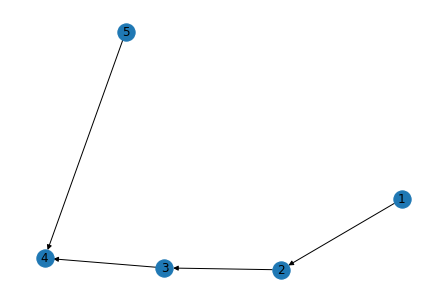

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty directed graph
G = nx.DiGraph()

# Add some nodes to the graph
G.add_nodes_from([1, 2, 3, 4,5])

# Add some edges to the graph
G.add_edge(1, 2)
G.add_edge(2, 3)
G.add_edge(3, 4)
G.add_edge(5, 4)

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

In [8]:
import tkinter as tk

class SLRParserGUI:
    def __init__(self):
        self.root = tk.Tk()
        self.root.title("SLR Parser")
        
        # Create a text box for the input program
        self.input_text = tk.Text(self.root)
        self.input_text.pack()
        
        # Create a button for parsing the input
        self.parse_button = tk.Button(self.root, text="Parse", command=self.parse)
        self.parse_button.pack()
        
        # Create a text box for the output parse tree
        self.output_text = tk.Text(self.root)
        self.output_text.pack()
        
    def parse(self):
        # Get the input program from the input text box
        input_program = self.input_text.get("1.0", "end-1c")
        
        # Parse the input program and create the parse tree
        parse_tree = self.create_parse_tree(input_program)
        
        # Display the parse tree in the output text box
        self.output_text.delete("1.0", "end")
        self.output_text.insert("1.0", parse_tree)
        
    def create_parse_tree(self, input_program):
        # Implement your parsing logic here
        pass

if __name__ == "__main__":
    gui = SLRParserGUI()
    gui.root.mainloop()


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Kashi\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\Kashi\AppData\Local\Temp\ipykernel_8940\2869858893.py", line 29, in parse
    self.output_text.insert("1.0", parse_tree)
  File "C:\Users\Kashi\anaconda3\lib\tkinter\__init__.py", line 3743, in insert
    self.tk.call((self._w, 'insert', index, chars) + args)
_tkinter.TclError: wrong # args: should be ".!text2 insert index chars ?tagList chars tagList ...?"


In [9]:
import cv2

# Load the cascade classifier for detecting faces
face_cascade = cv2.CascadeClassifier("data/haarcascades/haarcascade_frontalface_default.xml")

# Load the model for detecting facial expressions
model = load_expression_model()

# Read an image from the webcam
cap = cv2.VideoCapture(0)

while True:
    # Read the current frame from the webcam
    _, frame = cap.read()

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Iterate over the detected faces
    for (x, y, w, h) in faces:
        # Crop the face from the frame
        face = frame[y:y+h, x:x+w]

        # Detect the facial expression of the face
        expression = detect_expression(face, model)

        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Add a label with the detected expression to the frame
        cv2.putText(frame, expression, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    # Show the frame with the detected faces and expressions
    cv2.imshow("Frame", frame)

    # Break the loop if the user pressed the 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


NameError: name 'load_expression_model' is not defined